In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import layers, models, callbacks

In [2]:
# Load the dataset
df = pd.read_csv("merged_weather_pm25.csv")  # replace with your filename


In [3]:
# Drop non-numeric or unhelpful columns (like name, icon, preciptype)
df = df.drop(columns=["name"])

# Drop rows with missing values
df.dropna(inplace=True)

In [4]:
df.head()

,date,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,pm25
0,2024-01-01,76.2,60.6,67.1,76.2,60.6,67.1,60.7,80.7,0.0,...,304.2,1015.6,14.3,1.2,157.8,13.6,7,10,0.67,249
1,2024-01-02,71.7,58.9,63.6,71.7,58.9,63.6,57.9,82.2,0.0,...,312.7,1015.9,18.5,1.2,147.6,12.7,6,10,0.70,256
2,2024-01-03,73.4,59.0,63.8,73.4,59.0,63.8,57.9,81.8,0.0,...,353.6,1015.8,39.2,1.3,169.6,14.7,7,10,0.73,225
3,2024-01-04,75.4,57.2,65.1,75.4,57.2,65.1,59.2,82.1,0.0,...,79.3,1015.4,29.4,1.0,167.6,14.6,7,10,0.75,268
4,2024-01-05,71.2,57.2,63.6,71.2,57.2,63.6,59.7,87.6,0.0,...,97.9,1016.2,39.8,0.9,181.6,15.5,7,10,0.80,226


In [5]:
dates = df["date"]

In [6]:
X = df.drop(columns=["pm25",'date'])  
y = df["pm25"]


In [7]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
# Reshape for CNN input: (samples, features, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    # First Conv1D block
    layers.Conv1D(
        64, kernel_size=3, activation='relu', 
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train.shape[1], 1)
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Second Conv1D block
    layers.Conv1D(
        32, kernel_size=3, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Dense layers
    layers.Flatten(),
    layers.Dense(
        64, activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    layers.Dropout(0.4),
    
    layers.Dense(1)  # Regression output
])

In [11]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [13]:
# Train
history = model.fit(X_train, y_train, epochs=200, batch_size=4, validation_split=0.2, verbose=1, callbacks=[early_stop])

Epoch 1/200
68/68 [==============================] - 6s 16ms/step - loss: 31305.7480 - mae: 164.7054 - val_loss: 29986.7246 - val_mae: 160.3832
Epoch 2/200
68/68 [==============================] - 1s 10ms/step - loss: 15565.5205 - mae: 112.8261 - val_loss: 11640.9541 - val_mae: 92.6297
Epoch 3/200
68/68 [==============================] - 1s 9ms/step - loss: 3832.2097 - mae: 49.2182 - val_loss: 4475.6514 - val_mae: 54.2677
Epoch 4/200
68/68 [==============================] - 1s 10ms/step - loss: 3059.8027 - mae: 42.6495 - val_loss: 3254.3105 - val_mae: 45.0152
Epoch 5/200
68/68 [==============================] - 1s 12ms/step - loss: 2496.3638 - mae: 38.4249 - val_loss: 2275.0391 - val_mae: 37.2561
Epoch 6/200
68/68 [==============================] - 1s 11ms/step - loss: 2190.1501 - mae: 36.0095 - val_loss: 1748.7014 - val_mae: 32.7986
Epoch 7/200
68/68 [==============================] - 1s 11ms/step - loss: 1796.7634 - mae: 31.7017 - val_loss: 1735.9392 - val_mae: 32.1436
Epoch 8/200
68

3/3 [==============================] - 0s 25ms/step


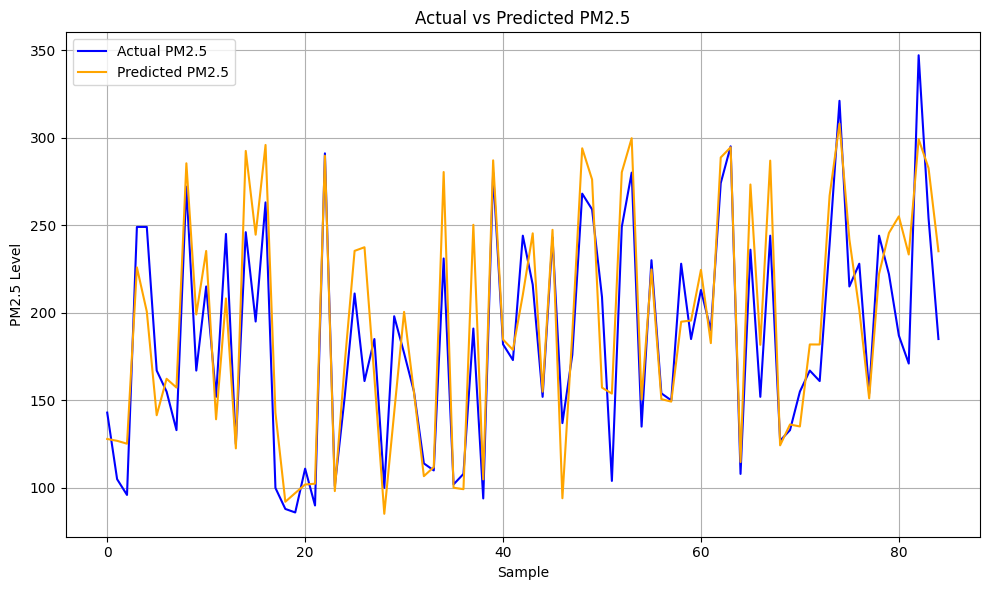

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred = model.predict(X_test).flatten()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual PM2.5", color='blue')
plt.plot(y_pred, label="Predicted PM2.5", color='orange')
plt.title("Actual vs Predicted PM2.5")
plt.xlabel("Sample")
plt.ylabel("PM2.5 Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
